
# DSAI Assignment 1
### Name: Bhosale Ratnesh Sambhajirao
### Roll No: 19MF10010



## Exercise 1

●	Use pretrained Resnet-50 to classify the image(use introduction notebook). <br>
1) Take an image and find its class.<br>
2) Create an adversarial example for a targeted attack by adding random noise to the image.<br>
3) Feed it to the Resenet for prediction and find the predicted class of the image. <br>
(add the image and prediction for both before and after adding the noise in the image to your document).


In [ ]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from torchvision import transforms
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

tensor([[[[0.0510, 0.0549, 0.0549,  ..., 0.1020, 0.1020, 0.1020],
          [0.0392, 0.0431, 0.0392,  ..., 0.1686, 0.1686, 0.1686],
          [0.0431, 0.0471, 0.0471,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [0.1451, 0.1608, 0.1608,  ..., 0.0392, 0.0431, 0.0431],
          [0.1216, 0.1216, 0.1412,  ..., 0.0314, 0.0314, 0.0353],
          [0.1176, 0.1255, 0.1294,  ..., 0.0353, 0.0314, 0.0353]],

         [[0.1255, 0.1255, 0.1255,  ..., 0.1294, 0.1294, 0.1294],
          [0.1255, 0.1294, 0.1255,  ..., 0.1333, 0.1333, 0.1333],
          [0.1216, 0.1255, 0.1255,  ..., 0.1412, 0.1412, 0.1412],
          ...,
          [0.1059, 0.1216, 0.1216,  ..., 0.0431, 0.0471, 0.0471],
          [0.0784, 0.0784, 0.0980,  ..., 0.0353, 0.0353, 0.0392],
          [0.0745, 0.0824, 0.0863,  ..., 0.0392, 0.0353, 0.0392]],

         [[0.1608, 0.1608, 0.1608,  ..., 0.1686, 0.1686, 0.1686],
          [0.0706, 0.0745, 0.0745,  ..., 0.0980, 0.0980, 0.0980],
          [0.0784, 0.0824, 0.0824,  ..., 0

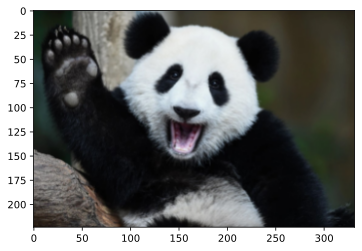

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("panda.jpg")

# Transform the image (to approximately zero-mean, unit variance) using the torchvision.transforms module
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]
print(pig_tensor)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

for i in range(1,2):
    rand=torch.rand(1, 3, 224, 224)
    plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

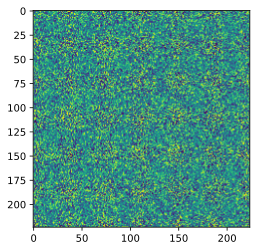

In [ ]:
zeros=torch.zeros(224,224)
ones=torch.ones(224,224)
rand=torch.rand(224, 224)
plt.imshow(rand)

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# form predictions
pred = model(norm(pig_tensor))

In [ ]:
"""
To find the highest likelihood class, we simply take the index of maximum value in this vector, 
and we can look this up in a list of imagenet classes to find the corresponding label.
"""
""
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

giant_panda


In [ ]:
# Evaluate the loss
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

9.863505363464355


Creating an adversarial example

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -9.863505363464355
5 -25.155487060546875
10 -23.414094924926758
15 -28.62392807006836
20 -24.52881622314453
25 -29.581005096435547
True class probability: 1.5643893515673857e-13


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  giant_panda
Predicted probability: 0.9999561309814453


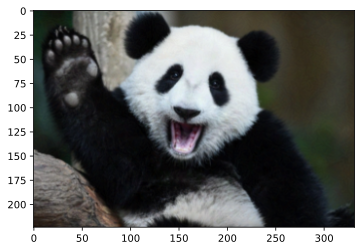

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

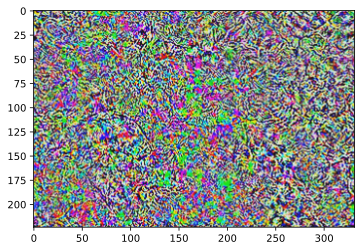

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [ ]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 1.640803337097168
10 -8.966255187988281
20 -18.547876358032227
30 -29.48309326171875
40 -38.01299285888672
50 -42.441349029541016
60 -48.23681640625
70 -52.66810607910156
80 -55.142822265625
90 -53.24313735961914


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9999985694885254


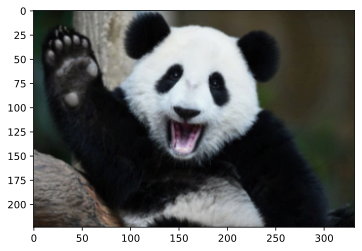

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

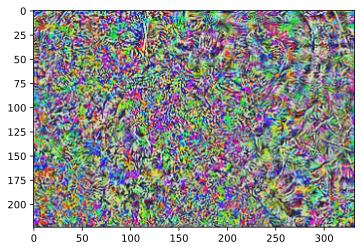

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

tensor([[[[0.0510, 0.0549, 0.0549,  ..., 0.1020, 0.1020, 0.1020],
          [0.0392, 0.0431, 0.0392,  ..., 0.1686, 0.1686, 0.1686],
          [0.0431, 0.0471, 0.0471,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [0.1451, 0.1608, 0.1608,  ..., 0.0392, 0.0431, 0.0431],
          [0.1216, 0.1216, 0.1412,  ..., 0.0314, 0.0314, 0.0353],
          [0.1176, 0.1255, 0.1294,  ..., 0.0353, 0.0314, 0.0353]],

         [[0.1255, 0.1255, 0.1255,  ..., 0.1294, 0.1294, 0.1294],
          [0.1255, 0.1294, 0.1255,  ..., 0.1333, 0.1333, 0.1333],
          [0.1216, 0.1255, 0.1255,  ..., 0.1412, 0.1412, 0.1412],
          ...,
          [0.1059, 0.1216, 0.1216,  ..., 0.0431, 0.0471, 0.0471],
          [0.0784, 0.0784, 0.0980,  ..., 0.0353, 0.0353, 0.0392],
          [0.0745, 0.0824, 0.0863,  ..., 0.0392, 0.0353, 0.0392]],

         [[0.1608, 0.1608, 0.1608,  ..., 0.1686, 0.1686, 0.1686],
          [0.0706, 0.0745, 0.0745,  ..., 0.0980, 0.0980, 0.0980],
          [0.0784, 0.0824, 0.0824,  ..., 0

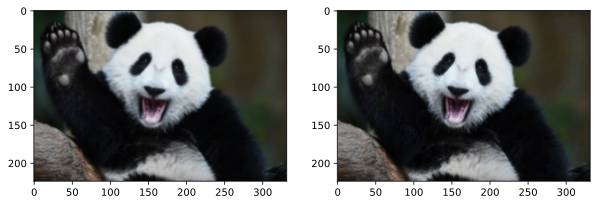

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
print(pig_tensor)
print(pig_tensor + delta)

## Exercise 2

●	Constructing adversarial examples using (use adversarial_examples notebook ) <br>
1)Fast Gradient Sign Method (FGSM) by varying epsilon between [0.1, 0.001](randomly take five values) <br>
2) Projected gradient descent(PGD)<br>
3) PGD with infinity norm<br>
4) PGD infinity norm with a targeted attack<br> 
5) PGD l2 norm by varying epsilon, alpha between [0.1, 0.001]<br>
(Take five values at random and do this for each method). Create a table with epsilon, alpha, and iterations as columns and optimization methods as rows <br>  
Compare the misclassification rate relative to all methods. Add screenshots of all outputs in the document. <br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Moving to NN

Text(0, 0.5, 'Output')

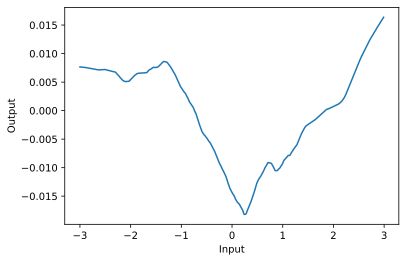

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [7]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.132383	0.517379	0.082800	0.293092
0.075733	0.264427	0.063200	0.223532
0.059017	0.209184	0.053200	0.183886
0.048533	0.172273	0.046500	0.156954
0.041117	0.146377	0.042400	0.141078
0.035433	0.127144	0.037000	0.123754
0.031533	0.112087	0.033800	0.113083
0.027933	0.100114	0.031600	0.104609
0.024700	0.090969	0.030100	0.102986
0.023167	0.082904	0.028100	0.095687


In [8]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234567	0.779224	0.079100	0.273246
0.064683	0.218699	0.049100	0.158574
0.042467	0.142816	0.039300	0.126334
0.031850	0.106830	0.031600	0.100235
0.024667	0.084727	0.030500	0.096128
0.020583	0.068081	0.027300	0.084701
0.017617	0.056569	0.025900	0.079224
0.014317	0.047128	0.025100	0.077882
0.011767	0.039319	0.024400	0.073938
0.009783	0.033133	0.021800	0.071125


In [9]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.207400	0.614856	0.027300	0.088949
0.024683	0.080292	0.016800	0.053454
0.017550	0.054924	0.014600	0.048802
0.013200	0.041128	0.015200	0.047476
0.009617	0.029812	0.012100	0.037920
0.004267	0.014401	0.010100	0.033025
0.003133	0.011421	0.009900	0.033314
0.002717	0.010184	0.009400	0.034034
0.002400	0.009251	0.009900	0.034004
0.002033	0.008410	0.010200	0.035039


In [10]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [11]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

### Lower bounding the inner maximization (i.e., adversarial attacks)

The Fast Gradient Sign Method (FGSM)

In [12]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [13]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

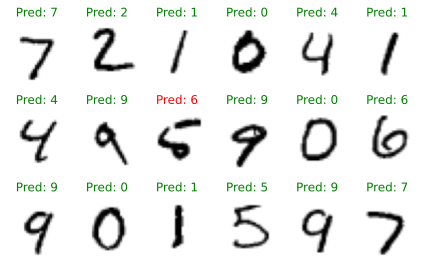

In [14]:
### Illustrate original predictions

yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

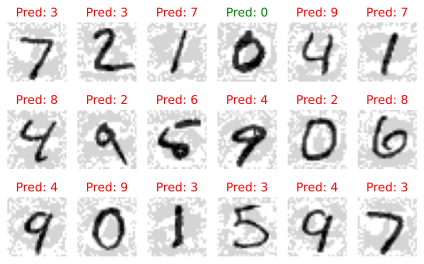

In [15]:
### Illustrate attacked images

## Epsilon = 0.1 
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

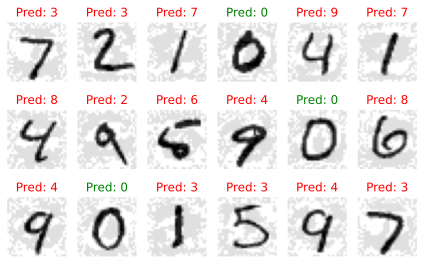

In [16]:
### Illustrate attacked images

## Epsilon = 0.07 
delta = fgsm(model_dnn_2, X, y, 0.07)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

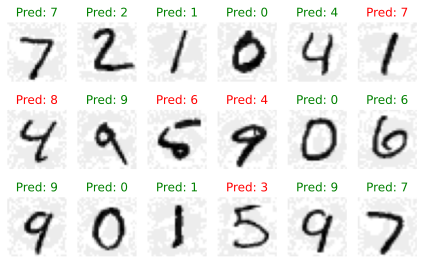

In [17]:
### Illustrate attacked images

## Epsilon = 0.04
delta = fgsm(model_dnn_2, X, y, 0.04)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

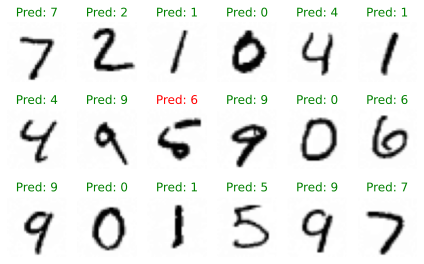

In [18]:
### Illustrate attacked images

## Epsilon = 0.005
delta = fgsm(model_dnn_2, X, y, 0.005)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

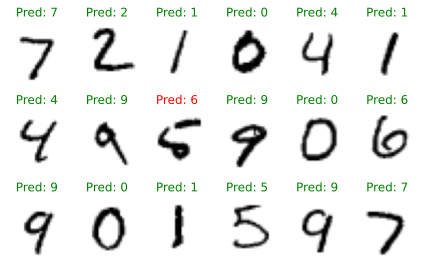

In [19]:
### Illustrate attacked images

## Epsilon = 0.001
delta = fgsm(model_dnn_2, X, y, 0.001)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

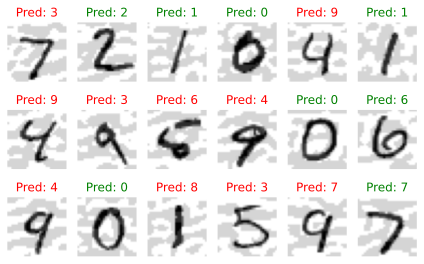

In [20]:
### Illustrate attacked images

# Epsilon = 0.1
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

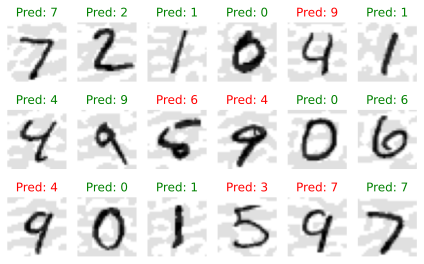

In [21]:
### Illustrate attacked images

# Epsilon = 0.07
delta = fgsm(model_cnn, X, y, 0.07)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

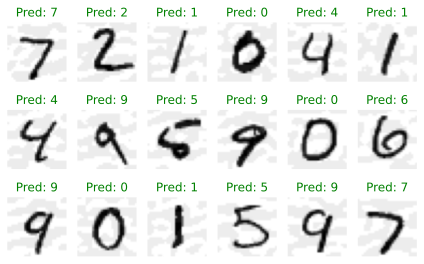

In [22]:
### Illustrate attacked images

# Epsilon = 0.04
delta = fgsm(model_cnn, X, y, 0.04)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

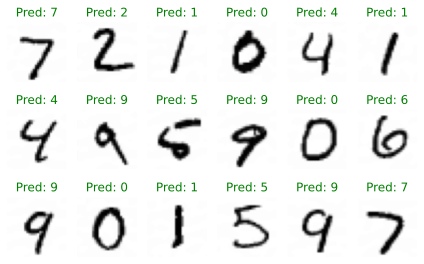

In [23]:
### Illustrate attacked images

# Epsilon = 0.005
delta = fgsm(model_cnn, X, y, 0.005)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

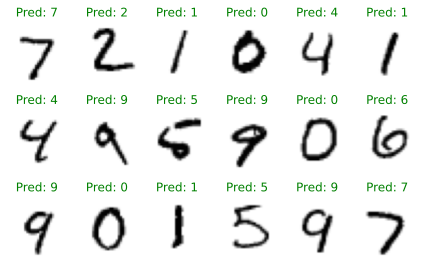

In [24]:
### Illustrate attacked images

# Epsilon = 0.001
delta = fgsm(model_cnn, X, y, 0.001)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9134
4-layer DNN: 0.9338
        CNN: 0.4452


### Projected gradient descent

In [25]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

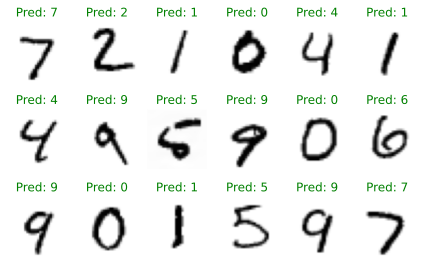

In [31]:
### Illustrate attacked images

## epsilon = 0.1 ; alpha = 0.001 
delta = pgd(model_cnn, X, y, 0.1, 0.001, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

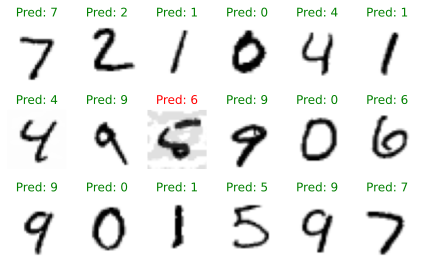

In [32]:
### Illustrate attacked images

## epsilon = 0.07 ; alpha = 0.02 
delta = pgd(model_cnn, X, y, 0.07, 0.02, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

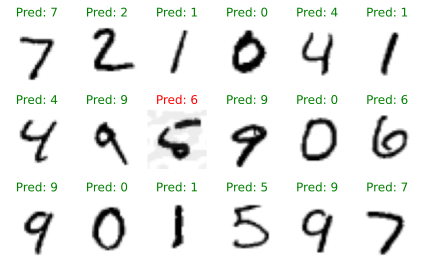

In [33]:
### Illustrate attacked images

## epsilon = 0.04 ; alpha = 0.008 
delta = pgd(model_cnn, X, y, 0.04, 0.008, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

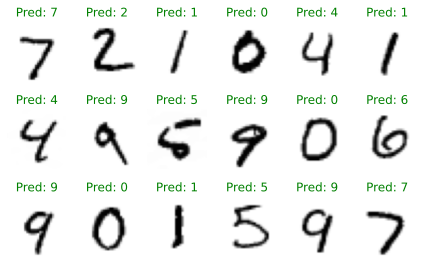

In [35]:
### Illustrate attacked images

## epsilon = 0.005 ; alpha = 0.01 
delta = pgd(model_cnn, X, y, 0.005, 0.01, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

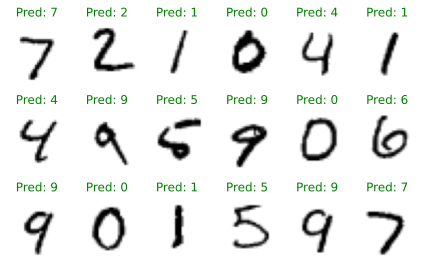

In [36]:
### Illustrate attacked images

## epsilon = 0.001 ; alpha = 0.06 
delta = pgd(model_cnn, X, y, 0.001, 0.06, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

3.1462698188988725e-06


### PGD with infinity norm

In [37]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

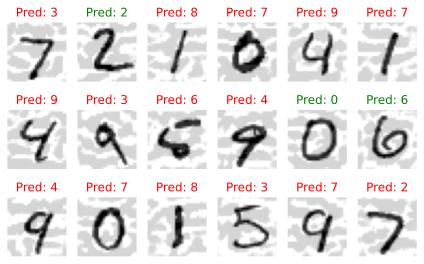

In [38]:
### Illustrate attacked images

# epsilon = 0.1 ; alpha = 0.02
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

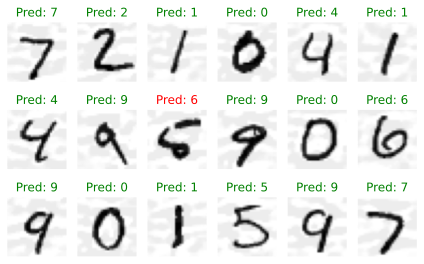

In [39]:
### Illustrate attacked images

# epsilon = 0.07 ; alpha = 0.001
delta = pgd_linf(model_cnn, X, y, epsilon=0.07, alpha=0.001, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

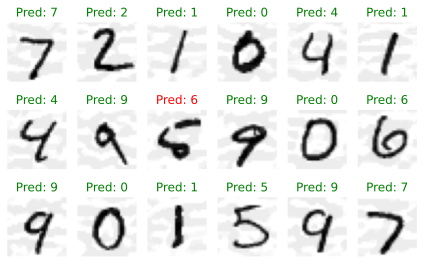

In [40]:
### Illustrate attacked images

# epsilon = 0.04 ; alpha = 0.05
delta = pgd_linf(model_cnn, X, y, epsilon=0.04, alpha=0.05, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

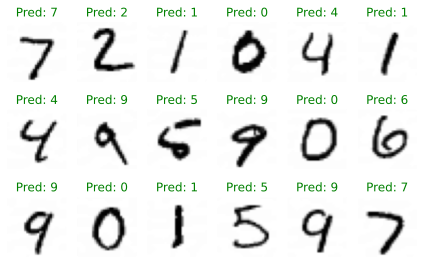

In [41]:
### Illustrate attacked images

# epsilon = 0.005 ; alpha = 0.01
delta = pgd_linf(model_cnn, X, y, epsilon=0.005, alpha=0.01, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

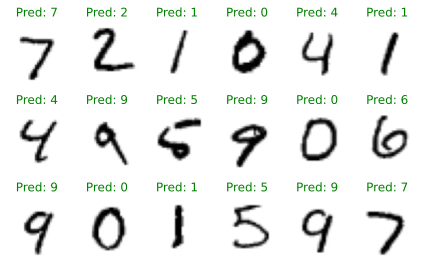

In [42]:
### Illustrate attacked images

# epsilon = 0.001 ; alpha = 0.1
delta = pgd_linf(model_cnn, X, y, epsilon=0.001, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [ ]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.748


### PGD infinity norm with a targeted attack 

In [43]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

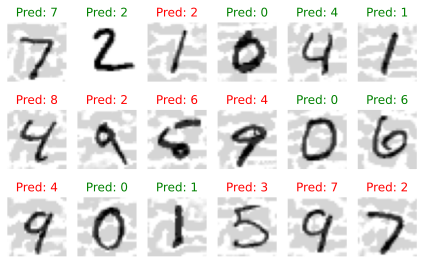

In [44]:
# epsilon = 0.1 ; alpha = 0.01
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

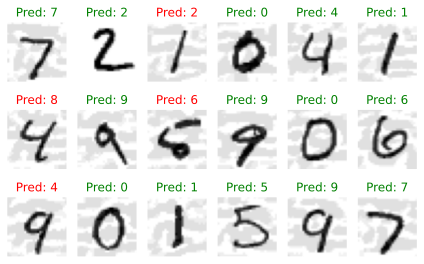

In [45]:
# epsilon = 0.07 ; alpha = 0.08
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.07, alpha=0.08, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

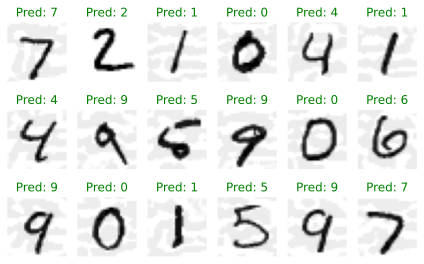

In [46]:
# epsilon = 0.04 ; alpha = 0.004
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.04, alpha=0.004, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

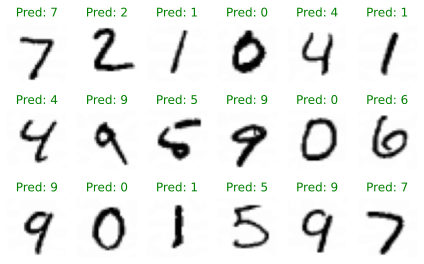

In [47]:
# epsilon = 0.005 ; alpha = 0.1
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.005, alpha=0.1, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

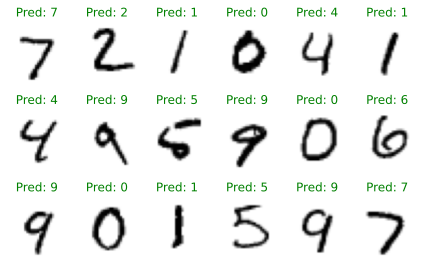

In [48]:
# epsilon = 0.001 ; alpha = 0.002
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.001, alpha=0.002, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [49]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

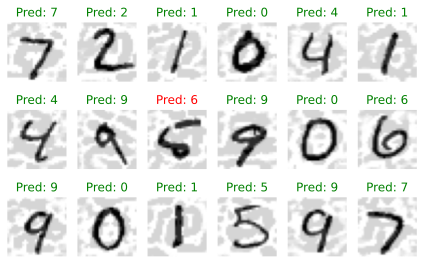

In [50]:
# epsilon = 0.1 ; alpha = 0.01
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

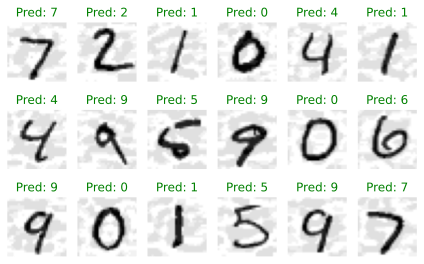

In [51]:
# epsilon = 0.07 ; alpha = 0.08
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.07, alpha=0.08, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

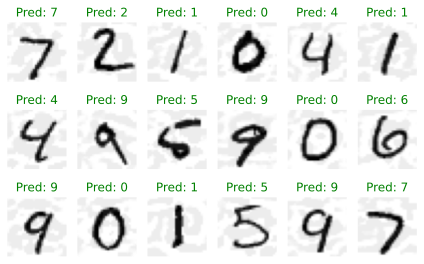

In [52]:
# epsilon = 0.04 ; alpha = 0.004
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.04, alpha=0.004, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

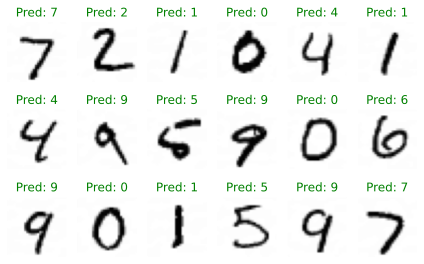

In [53]:
# epsilon = 0.005 ; alpha = 0.1
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.005, alpha=0.1, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

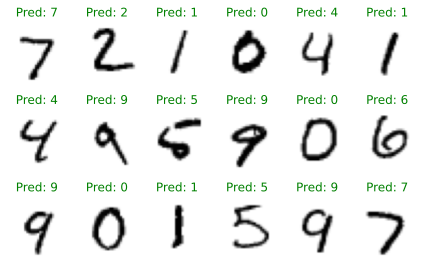

In [54]:
# epsilon = 0.001 ; alpha = 0.002
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.001, alpha=0.002, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

### PGD l2 norm by varying epsilon, alpha between [0.1, 0.001]

In [55]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

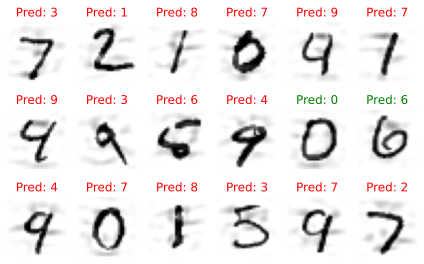

In [56]:
# epsilon = 2 ; alpha = 0.1
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

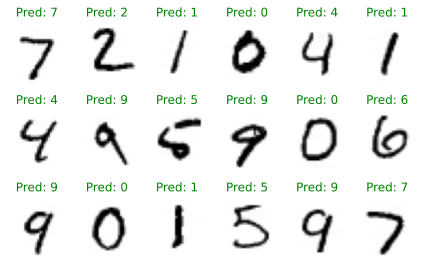

In [57]:
# epsilon = 0.1 ; alpha = 0.1
delta = pgd_l2(model_cnn, X, y, epsilon=0.1, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

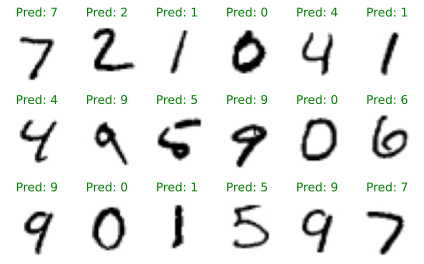

In [58]:
# epsilon = 0.07 ; alpha = 0.001
delta = pgd_l2(model_cnn, X, y, epsilon=0.07, alpha=0.001, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

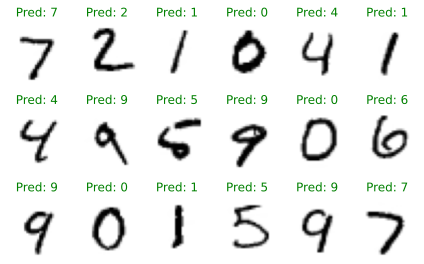

In [60]:
# epsilon = 0.04 ; alpha = 0.05
delta = pgd_l2(model_cnn, X, y, epsilon=0.04, alpha=0.05, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

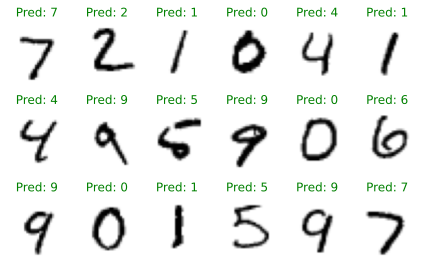

In [61]:
# epsilon = 0.005 ; alpha = 0.09
delta = pgd_l2(model_cnn, X, y, epsilon=0.005, alpha=0.09, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

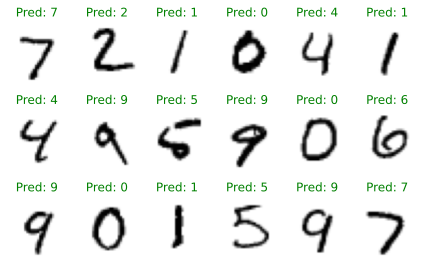

In [63]:
# epsilon = 0.001 ; alpha = 0.09
delta = pgd_l2(model_cnn, X, y, epsilon=0.001, alpha=0.001, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)